# Data processing and analysis - Building on top of Neo
Based on tutorial material by Cristiano Koehler

Until now we have discussed the advantages gained by using Neo for standardized data storage via conversion to standardized formats and as data representation to develop custom visualizations and analysis. However, the most important aspect is that for classic anlysis it not necessary any more to implement these as other software packages are building on top of the Neo data representation!

![neo_as_interface](./neo_material/neo_as_interface.svg)

## Elephant - the Electrophysiology Analysis Toolkit
![](elephant_material/elephant_logo_sidebar.png)



provides analysis on different levels
- data preprocessing
    - filtering, z-score
    - cross-correlation
- classic analysis
    - spike train statistics & correlation
    - phase calculation
    - spectral analysis
    - kernel convolution
    - spike-triggered LFP & phase
- advanced:
    - surrogate generation
    - detection of synchronous spike patterns: CAD, Unitary Events, **SPADE**, ASSET, CuBIC
    - detection of non-stationary processes
    - Gaussian-Process Factor Analysis (GPFA)
- ...

see also [https://elephant.readthedocs.io/](https://elephant.readthedocs.io/)

### Elephant
- works on `Neo`, `Numpy` or `Quantities` objects
- optimal metadata usage for `Neo` objects
- open source & community project
- extension suggestions -> open an issue & PR on [github](https://github.com/NeuralEnsemble/elephant)

## Viziphant
![](./elephant_material/viziphant_logo_sidebar.png)

Used to provide simple visualizations of analysis results
 
see also [https://viziphant.readthedocs.io/](https://viziphant.readthedocs.io/)

## Imports and preparation

In [1]:
import quantities as pq
import neo.utils
import elephant
import viziphant
import nixio
import matplotlib.pyplot as plt
%matplotlib inline

On Linux you can download the compiled nix file via the command below. On other systems, please download the file manually from here and save it in the same folder as this notebook.

In [2]:
!wget -O i140703-001.nix https://gin.g-node.org/sprenger/multielectrode_grasp/raw/dataset_nix/datasets_nix/i140703-001_cut_74sec.nix

## Loading and preparing the data for the analysis

We start by loading the data file and extracting the trials of interest.
Our objective is to retain only the trials where the monkey performed correctly, for one of the four trial types in the experiment.

Let's start by reading the dataset `i140703-001.nix` into a `neo.Block`. Then, we will select the proper `neo.Segment` object
with the recording data.

In [3]:
with neo.io.NixIO('i140703-001.nix', 'ro') as io:
    block = io.read_block()

# Use first segment in the file
segment = block.segments[0]

The events in `segment.events[0]` correspond to inputs from the digital port of the acquisition system,
with the important time points during the trial. They have labels stored as the `trial_event_labels` annotation.
In previous sessions, you learned the details about the experiment.

The start of the trial is identified by the `TS-ON` label. We will use it as a reference to cut our data from `segment`.
We will cut a slice of total 2 s duration after `TS-ON`.

We can also use the `performance_in_trial_str` annotation to select the trials where the monkey performed
correctly, and `belongs_to_trialtype` to select one of the four trial types. Here, we choose `SGHF`, i.e., side-grips (SG)
with a high force (HF).

Instead of the manual approach to selecting these events as used in tutorial 2, we use the convenience function `get_events()`
from the `neo.utils` module.

In [4]:
start_events = neo.utils.get_events(
    segment,
    trial_event_labels='TS-ON',
    belongs_to_trialtype='SGHF',
    performance_in_trial_str='correct_trial')

Having the `TS-ON` events as the start time points, we now define epochs with the desired duration of 2 s and store them as the variable
`trial_epochs`. When fetching the events, we consider only the first item returned `start_events[0]` which corresponds
to the events recorded through the digital port of the acquisition system.

In [5]:
# Create epochs between the events
trial_epochs = neo.utils.add_epoch(
    segment,
    event1=start_events[0],     # first Neo Event contains relevant data
    pre=0*pq.ms,
    post=2000*pq.ms,
    array_annotations=start_events[0].array_annotations)

As next step, let's cut our original segment of continuous data into separate segments, one for each epoch (trial).
To this end, we create a new block called `trials` to store the new segments.

Use the `reset_time` parameter to set the start times of each individual trial to zero, so that they are aligned to `TS-ON`.

In [6]:
# Create the new block
trials = neo.Block()

# Cut the recording segment into the trials, as defined by the epochs
trials.segments = neo.utils.cut_segment_by_epoch(segment, trial_epochs, reset_time=True)

## Selecting a single trial

The first analyses will be for a single trial. Let's then select the first trial available as the variable `trial`.

We will also use the events from the digital input port. Like before, they are the first `neo.Event` object in `trial.events`.
Let's select the digital events of the trial in a variable called `trial_events` and inspect the annotations, to check if we
got the correct data.

In [7]:
# Select first segment as the trial for analysis
trial = trials.segments[0]

# Select first event of the trial
trial_events = trial.events[0]

# Inspect
print(trial_events.labels)
print(trial_events.array_annotations)

['TS-ON' 'WS-ON' 'CUE-ON' 'CUE-OFF']
{'trial_id': array([1, 1, 1, 1]), 'trial_timestamp_id': array([39424, 39424, 39424, 39424]), 'performance_in_trial': array([255, 255, 255, 255]), 'performance_in_trial_str': array(['correct_trial', 'correct_trial', 'correct_trial', 'correct_trial'],
      dtype='<U13'), 'belongs_to_trialtype': array(['SGHF', 'SGHF', 'SGHF', 'SGHF'], dtype='<U4'), 'trial_event_labels': array(['TS-ON', 'WS-ON', 'CUE-ON', 'CUE-OFF'], dtype='<U11'), 'trial_reject_HFC': array([False, False, False, False]), 'trial_reject_LFC': array([False, False, False, False]), 'trial_reject_IFC': array([ True,  True,  True,  True])}


## Selecting spike trains with single-unit activity (SUA)

An electrode may record spike trains originated from several neurons in the vicinity. After the process of spike sorting,
spike trains that contain the activity from only a single neuron are obtained. These are referred to as single-unit activity (SUA).

In [8]:
trial.spiketrains[0].annotations

{'nix_name': 'neo.spiketrain.22a41c20c0614a238d32dea2d46673ca',
 'id': 'Unit 1000',
 'channel_id': 1,
 'unit_id': 0,
 'unit_tag': 'unclassified',
 'electrode_reject_HFC': False,
 'electrode_reject_LFC': False,
 'electrode_reject_IFC': False,
 'connector_aligned_id': 93,
 'coordinate_x': array(0.8) * mm,
 'coordinate_y': array(3.6) * mm,
 'sua': False,
 'mua': False,
 'noise': True}

For our analysis, we will consider only the spike trains in the trial that are classified as SUA. This information has been recorded
in the boolean annotation `sua` of each spike train

We will also consider only the SUA spike trains that fire more than 10000 spikes in the complete recording session, as well as without any noise.
We can do that by checking the relevant annotations. Let's store this in a final list called `sua_spiketrains_with_spikes`.

In [9]:
# Select only SUA spike trains with spikes and certain quality criteria

sua_spiketrains_with_spikes = [spiketrain for spiketrain in trial.spiketrains if
                                   spiketrain.annotations['sua'] and                          # Is SUA
                                   not spiketrain.annotations['electrode_reject_HFC'] and     # Bad quality is marked as True
                                   not spiketrain.annotations['electrode_reject_IFC'] and
                                   not spiketrain.annotations['electrode_reject_LFC'] and
                                   not spiketrain.annotations['noise'] and                    # If noisy, is market as True
                                   spiketrain.annotations['spike_count'] > 10000]             # Spike count

## Plotting a raster plot and firing rates across SUAs

As a first step in the analysis of spike trains, it is good to have an overview of the spiking activity of all
neurons along the duration of the trial, with respect to the events. We can do that by plotting the raster plot,
population histogram and mean firing rate for the SUAs in the trial:

* The raster plot shows the time points where each spike occurred, for the individual neurons.
* The mean firing rate is the temporal average of the number of spikes of an individual neuron in the trial.
* The population histogram shows the number of spikes that occurred during small intervals along the trial, considering all neurons.

Viziphant provides the function `rasterplot_rates` to easily produce the plots.

The immediate output of the plotting function does not have the events. We will add them manually using
Viziphant's `add_event` function.

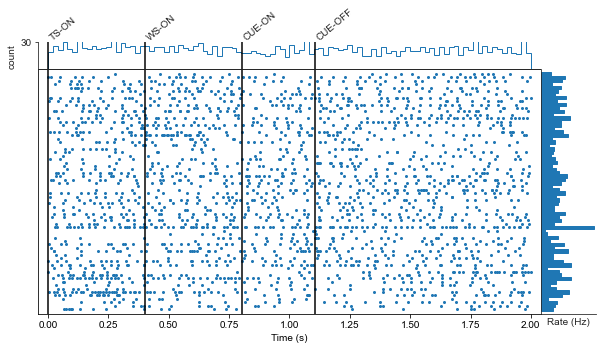

In [10]:
# Create the raster plot of the SUA spike trains
#   `axes` is the main raster plot.
#   `axes_histx`: population histogram (above the raster plot)
#   `axes_histy`: mean firing rates for each neuron (right)
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(10,5))
axes, axes_histx, axes_histy = viziphant.rasterplot.rasterplot_rates(
    sua_spiketrains_with_spikes, ax=fig.axes[0])
# Label the mean firing rate histogram
axes_histy.set_xlabel('Rate (Hz)')
# Add vertical lines for all important trial events
# (remove the last element in case there is overlap with the STOP event)
viziphant.events.add_event([axes_histx, axes], trial_events, key='trial_event_labels')

## Visualize the instantaneous firing rate of one neuron in the trial

The mean firing rate is just the temporal average of the number of spikes per time in the spiking activity of the neuron for the
whole trial. We can have a time-varying estimate of the firing rate along the duration of the trial by computing the instantaneous rate.

For this estimation, Elephant's `statistics` module provides the `instantaneous_rate` function. The function performs kernel
convolution: each spike that ocurred during the trial is blurred with a kernel function. The bandwidth of the kernel function is
controlled by the parameter `sigma`. Different types of kernel and bandwidths can be selected for more or less smooth estimates.

Let's plot the instantaneous rate for one neuron that we are analyzing. Let's use a Gaussian kernel with two different `sigma`
parameters: `20 ms` or `100 ms`. Use `.1 ms` as `sampling_period`.

In [11]:
[(idx, val.name) for idx, val in enumerate(
    sua_spiketrains_with_spikes) if val.annotations['SNR'] > 10]

[(9, 'ch14#1'), (64, 'ch85#1')]

In [12]:
# Select one neuron from the SUA list
neuron = sua_spiketrains_with_spikes[9]
print(neuron.name)

ch14#1


In [13]:
# Define kernels
kernel_20 = elephant.kernels.GaussianKernel(sigma=20*pq.ms)
kernel_100 = elephant.kernels.GaussianKernel(sigma=100*pq.ms)

# Define the sampling period for the instantaneous rate function
sampling_period = .1*pq.ms

rates_20 = elephant.statistics.instantaneous_rate(
    neuron, kernel=kernel_20, sampling_period=sampling_period)
rates_100 = elephant.statistics.instantaneous_rate(
    neuron, kernel=kernel_100, sampling_period=sampling_period)

Execute the code below to plot the spike train together with the two rate profiles that we calculated.
The spike times will be added to the bottom of each plot. Note that the parameters of the rate computations
are retained in the resulting rate variables, which in turn are Neo `AnalogSignal` objects.

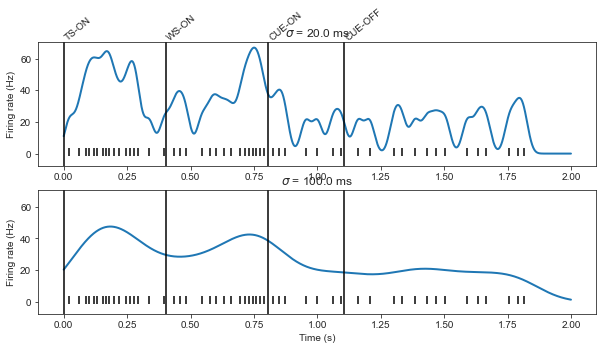

In [14]:
fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10,5))
for plot, rates in enumerate([rates_20, rates_100]):
    axes[plot].plot(rates.times.rescale(pq.s), rates, linewidth=2)
    axes[plot].eventplot(neuron.magnitude, color='black', linelengths=5)
    axes[plot].set_ylabel("Firing rate (Hz)")
    axes[plot].set_title(f"$\sigma$ = {rates.annotations['kernel']['sigma']}")
viziphant.events.add_event(axes, trial_events, key='trial_event_labels')
axes[-1].set_xlabel("Time (s)");

We can see that the smoothness of the rate curve is affected by the `sigma` parameter.
Elephant can try to estimate the best kernel bandwidth for a Gaussian kernel by using `'auto'` as the value of the
`kernel` parameter. Let's try this option.

In [15]:
rates_auto = elephant.statistics.instantaneous_rate(
    neuron, kernel='auto', sampling_period=sampling_period)

Execute the code below to plot the instantaneous firing rate obtained from the automatic kernel bandwidth.

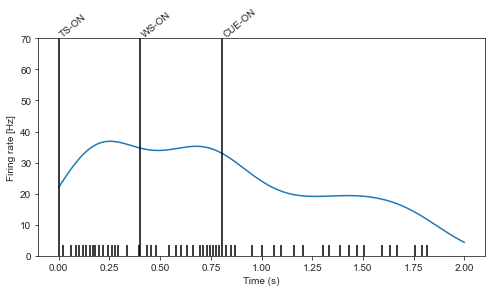

In [16]:
fig, axes = plt.subplots(figsize=(8,4))
axes.plot(rates_auto.times.rescale(pq.s), rates_auto)
axes.eventplot(neuron.magnitude, color='black', linelengths=5)
axes.set_ylabel("Firing rate [Hz]")
axes.set_xlabel("Time (s)")
axes.set_ylim([0,70])
viziphant.events.add_event(axes, trial_events[:-1], key='trial_event_labels')

Finally, let's compute and plot the instantaneous firing rates for all the SUAs in the trial.

You can pass the list with all spike trains for the `instantaneous_rate` function, to generate a 2D-matrix.
Use `kernel_100` as the `kernel` parameter and `.1 ms` as `sampling_period`.

In [17]:
all_rates = elephant.statistics.instantaneous_rate(
    sua_spiketrains_with_spikes, kernel=kernel_100, sampling_period=sampling_period)

Now use the Viziphant function `plot_instantaneous_rates_colormesh` to plot the rates.

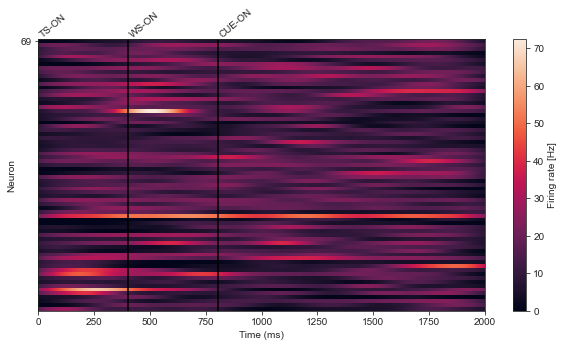

In [18]:
# Create the axes, setting the figure size
fig, axes = plt.subplots(figsize=(10,5))
# Plot the rates using the axes
viziphant.statistics.plot_instantaneous_rates_colormesh(all_rates, axes=axes)
# Add the events (need to rescale to the same units as the sampling period in `all_rates`)
viziphant.events.add_event(
    axes, trial_events[:-1].rescale(all_rates.sampling_period.units),
    key='trial_event_labels')

## Investigate the spike train correlations in the selected trial

From the rasterplot that we generated above, it is difficult to assess if there are correlations between the spike trains.

To investigate that, Elephant provides functions to calculate and plot the cross-correlation matrix. This matrix
quantifies the similarity for each pair of spike trains in the trial. We start by binning the spike trains
that we selected in the trial (SUAs with spiking activity in `sua_spiketrains_with_spikes`). Therefore, we are
obtaining the number of spikes that occurred during small intervals along the trial, for each individual neuron.
Let's use a bin size of 3 ms.

In [19]:
binned_spiketrains = elephant.conversion.BinnedSpikeTrain(
    sua_spiketrains_with_spikes, binsize=3*pq.ms)

/home/denker/miniconda3/envs/2021_nix_workshop/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/denker/miniconda3/envs/2021_nix_workshop/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/denker/miniconda3/envs/2021_nix_workshop/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


If we inspect the spike times of one neuron, we can see that if the neuron fired in a particular bin,
the `BinnedSpikeTrain` object will store the value 1.

In [20]:
print(sua_spiketrains_with_spikes[0])

[0.06746667 0.0734     0.08793333 0.096      0.1015     0.1333
 0.1863     0.2388     0.39636667 0.46973333 0.4999     0.68813333
 0.73756667 0.77723333 1.25816667 1.46953333 1.69226667 1.75393333
 1.76566667 1.84573333 1.97663333] s


In [21]:
# Index of the 3 ms bin that the spike occurred
sua_spiketrains_with_spikes[0].times / (0.003 * pq.s)

array([ 22.48888889,  24.46666667,  29.31111111,  32.        ,
        33.83333333,  44.43333333,  62.1       ,  79.6       ,
       132.12222222, 156.57777778, 166.63333333, 229.37777778,
       245.85555556, 259.07777778, 419.38888889, 489.84444444,
       564.08888889, 584.64444444, 588.55555556, 615.24444444,
       658.87777778]) * dimensionless

In [22]:
print(binned_spiketrains.to_array()[0,0:50])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0]


The binning above showed several warnings that happened due to the machine error precision of floating point computation. Since now we're aware of it, let's filter them out throughout the rest of the notebook.

In [23]:
import warnings
warnings.filterwarnings("ignore")

Then we calculate the cross-correlation matrix of the binned spikes using the `correlation_coefficient`
function from the `statistics` module.

In [24]:
cross_corr_matrix = elephant.spike_train_correlation.correlation_coefficient(
    binned_spiketrains)

We visualize the matrix using the `plot_corrcoef` function of Viziphant. To better visualize the
coefficients, we will set `correlation_range` to `'auto'`, to use the color bar only in the range of the
obtained coefficients. We will also not plot the values along the main diagonal, as those are equal to 1, by
setting `remove_diagonal` to True.

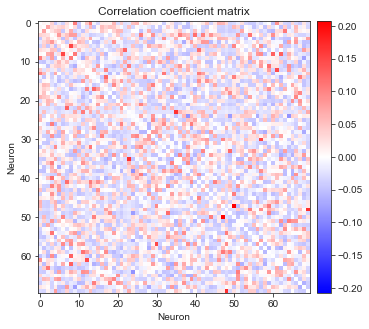

In [25]:
# Create the axes, setting the figure size
fig, axes = plt.subplots(figsize=(10,5))
# Plot the correlation matrix
viziphant.spike_train_correlation.plot_corrcoef(
    cross_corr_matrix, axes=axes,correlation_range='auto',remove_diagonal=True)
# Set labels and title
axes.set_xlabel('Neuron')
axes.set_ylabel('Neuron')
axes.set_title("Correlation coefficient matrix");

## Save results to NIX

Now that we generated several analysis results, we'd like to save them in a NIX file.

Let's look at the rate estimates first. These are essentially time series that are represented as `AnalogSignal`
objects. The advantage of using such an object instead of a `numpy` array is that it can capture information
such as physical units or additional annotations indicating parameters of the analysis. As we've seen above,
Elephant recorded such parameters automatically:

In [26]:
print(rates_100.dimensionality)
print(rates_100.t_stop)
print(rates_100.annotations)

Hz
2.0 s
{'t_stop': array(2.) * s, 'kernel': {'type': 'GaussianKernel', 'sigma': '100.0 ms', 'invert': False}}


This way, we can save analysis results to disk with important information indicating how these were generated.
We can save these results using the Neo NIX IO. To this end, we compile results into a Neo `Block`, and all
rate results in particular into a `Segment`.

In [27]:
results_block=neo.Block(name="Analysis")
results_segment=neo.Segment(name="Rate Analyses")
results_block.segments.append(results_segment)
results_segment.analogsignals.append(rates_100)
results_segment.analogsignals.append(rates_20)
results_segment.analogsignals.append(rates_auto)

with neo.io.NixIO('results.nix', 'ow') as io:
    io.write(results_block)

If we think about a collaborator who may want to build upon your results, maybe it would be good to also supply him/her with the data used to calculate these results. Luckily, these are available as a Neo `Block` in the variable `trials` which we created in the beginning of this tutorial. Saving this data to the same NIX file, we can combine analysis input and output in a single, compact file.

In [28]:
with neo.io.NixIO('results.nix', 'rw') as io:
    io.write(trials)

Some analysis results are represented in structures that do not fit Neo structures, for example, the correlation matrix
we calculated above. While efforts to create fitting representations for such analysis results are underway, we can use
NIX nevertheless to save these results into the same file as a separate NIX Block. This way, we end up with one single
file containing all analysis results.

In [29]:
nixfile = nixio.File.open("results.nix", nixio.FileMode.ReadWrite)
nixblock = nixfile.create_block("correlation_results", "nix.session")
data_array = nixblock.create_data_array(
    "correlation_matrix", "nix.sampled.multichannel", 
    data=cross_corr_matrix,
    label="cross-correlation coefficient", 
    unit="dimensionless")
data_array.append_set_dimension(
    labels=["neuron %i" % i for i in range(cross_corr_matrix.shape[0])])
data_array.append_set_dimension(
    labels=["neuron %i" % i for i in range(cross_corr_matrix.shape[0])])
nixfile.close()
